In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

## Build Vector DB

This notebook assumes that you have run the `data_prep.ipynb` notebook beforehand, so there should be `projects_data_en.json` file in the current directory.

### UpstageEmbeddingFunction for ChromaDB

In [ ]:
import chromadb
import numpy as np
from openai import OpenAI
from chromadb import Documents, EmbeddingFunction, Embeddings

# Configure OpenAI client to use Upstage API
client = OpenAI(
    base_url="https://api.upstage.ai/v1",
    api_key=os.getenv("UPSTAGE_API_KEY")
)

chroma_client = chromadb.PersistentClient(path="./chroma_db")
embedding_context_length = 4000

class UpstageEmbeddingFunction(EmbeddingFunction[Documents]):
    def __init__(
        self,
        client,
        model_name: str = "embedding-query",
    ):
        self.client = client
        self.model_name = model_name

    def __call__(self, input: Documents) -> Embeddings:
        if not all(isinstance(item, str) for item in input):
            raise ValueError("Solar embedding only supports text documents, not images")

        batch_process_result = self.client.embeddings.create(model=self.model_name, input=input).data
        passage_embedding_list = [i.embedding for i in batch_process_result]
        return np.array(passage_embedding_list, dtype=np.float32)

embedding_fn = UpstageEmbeddingFunction(client)

### Randomly remove participants from randomly selected projects

In [10]:
import json
import random
random.seed(42)

# Load the projects data
with open('projects_data_en.json', 'r', encoding='utf-8') as f:
    projects_data = json.load(f)

selected_projects = random.sample(projects_data, 5)
print(f"Loaded {len(projects_data)} projects")
print(f"Selected {len(selected_projects)} projects")

# Remove a random participant from each selected project
for project in selected_projects:
    print(f"project: {project.get('project_name', 'Unknown')}")
    
    if 'participants' in project and project['participants']:
        # Select a random participant to remove
        participant_to_remove = random.choice(project['participants'])
        project['participants'].remove(participant_to_remove)
        print(f"\tRemoved participant '{participant_to_remove}' from project '{project.get('title', 'Unknown')}'")
    else:
        print(f"\tNo participants to remove from project '{project.get('title', 'Unknown')}'")

    print(f"\tthe number of required roles: {len(project['required_roles'])}")
    print(f"\tthe number of current participants: {len(project['participants'])}")


Loaded 45 projects
Selected 5 projects
project: AI-driven Personal Finance Management Platform
	Removed participant '{'name': 'Bob Lee', 'role': 'Financial Analyst', 'experience_years': 8, 'skills': ['Financial Modeling', 'Risk Assessment', 'Data Analysis'], 'performance_rating': 4.2}' from project 'Unknown'
	the number of required roles: 5
	the number of current participants: 4
project: Educational Gamification Platform
	Removed participant '{'name': 'Liam Chen', 'role': 'UI/UX Designer', 'experience_years': 3, 'skills': ['User Experience Design', 'Prototyping', 'Visual Design'], 'performance_rating': 4.5}' from project 'Unknown'
	the number of required roles: 7
	the number of current participants: 6
project: Smart Inventory Management System
	Removed participant '{'name': 'Michael Lee', 'role': 'Business Analyst', 'experience_years': 3, 'skills': ['Requirements Gathering', 'Process Modeling', 'Business Intelligence'], 'performance_rating': 4}' from project 'Unknown'
	the number of re

### Store data into ChromaDB

In [11]:
try:
    chroma_client.delete_collection(name="selected_projects")
    print("Collection deleted")
except Exception as e:
    print(e)

collection = chroma_client.create_collection(name="selected_projects", embedding_function=embedding_fn)
print("Collection created")

Collection [selected_projects] does not exists
Collection created


In [12]:
import hashlib
from tqdm import tqdm

# Generate hash based on string
def generate_hash(text):
    """Generate a hash (SHA-256) based on input string"""
    return hashlib.sha256(text.encode('utf-8')).hexdigest()

for project in tqdm(selected_projects):
    id = generate_hash(project["descriptive_summary"])

    collection.add(
        ids=[id],
        documents=[project["descriptive_summary"]],
        metadatas=[{"data": str(project)}]
    )

100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


## Agentic System w/ LangGraph

### Imports

In [ ]:
import re
import json
import requests

from pydantic import BaseModel, Field

from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_upstage import ChatUpstage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.tools import tool

from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langgraph.graph import StateGraph, START, END

### Helper functions

In [242]:
def escape_braces(obj) -> str:
    """Escape all curly braces in a dictionary or string for safe use in ChatPromptTemplate."""
    if isinstance(obj, dict):
        obj = str(obj)
    return re.sub(r'[{]', '{{', re.sub(r'[}]', '}}', obj))

def find_json_snippet(raw_snippet):
	json_parsed_string = None

	json_start_index = raw_snippet.find('{')
	json_end_index = raw_snippet.rfind('}')

	if json_start_index >= 0 and json_end_index >= 0:
		json_snippet = raw_snippet[json_start_index:json_end_index+1]
		try:
			json_parsed_string = json.loads(json_snippet, strict=False)
		except:
			raise ValueError('......failed to parse string into JSON format')
	else:
		raise ValueError('......No JSON code snippet found in string.')

	return json_parsed_string

def parse_first_json_snippet(snippet):
	json_parsed_string = None

	if isinstance(snippet, list):
		for snippet_piece in snippet:
			try:
				json_parsed_string = find_json_snippet(snippet_piece)
				return json_parsed_string
			except:
				pass
	else:
		try:
			json_parsed_string = find_json_snippet(snippet)
		except Exception as e:
			print(e)
			raise ValueError()

	return json_parsed_string

## Define DocumentParse tool

In [243]:
def get_document_parse_response(filename, api_key):
    url = "https://api.upstage.ai/v1/document-ai/document-parse"

    headers = {"Authorization": f"Bearer {api_key}"}
    files = {"document": open(filename, "rb")}
    data = {"output_formats": "['markdown']"}

    response = requests.post(url, headers=headers, files=files, data=data)
    upstage_response = json.loads(response.text)
    return upstage_response

def get_md_with_document_parse(pdf_path):
    upstage_response = get_document_parse_response(pdf_path, UPSTAGE_API_KEY)
    markdown = upstage_response['content']['markdown']
    return markdown

@tool
def parse_pdf_to_md(pdf_path: str):
    """Use this tool to parse pdf to markdown. Use this tool when pdf path is found in the user's input"""
    
    print("Parsing in progress.....")
    md = get_md_with_document_parse(pdf_path)
    print("Parsing done ✅")
    return (
        f"successfullly parsed the pdf of resume at {pdf_path}. Use this markdown for the downstream tasks. "
        f"The markdown is: {md}"
    )

In [245]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=tool_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [ ]:
tools = [parse_pdf_to_md]

### Dataclasses

In [ ]:
class ParticipatedProject(BaseModel):
    """
    Represents a project the participant has been involved in.
    
    Attributes:
        project_name: The name of the participated project
        role: The role of the participant in the project
    """
    project_name: str = Field(description="The name of the participated project")
    role: str = Field(description="The role of the participant in the project")

class Participant(BaseModel):
    """
    Represents a participant with their personal information, skills, and project history.
    
    Attributes:
        name: The participant's full name
        skills: List of technical or professional skills the participant possesses
        participated_projects: List of projects the participant has been involved in
    """
    name: str = Field(
        default="",
        description="The name of the participant"
    )
    skills: List[str] = Field(
        default_factory=list,                      # ← empty list if missing
        description="The skills of the participant",
    )
    participated_projects: List["ParticipatedProject"] = Field(
        default_factory=list,                      # ← empty list if missing
        description="The projects the participant has participated in",
    )

### State

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    participant_info: Participant | None
    retrieved_projects: List[str] | None
    query: str | None

### Chat instances

In [ ]:
solar = ChatUpstage(model="solar-pro-250422")
solar_w_tools = solar.bind_tools(tools)

### Nodes

In [276]:
def frontend_interface_agent(state: State):
    """Agent that calls the LLM with tools, deciding the next step."""
    print("--- Calling Model Agent ---")
    messages = state['messages']
    response = solar_w_tools.invoke(messages)
    # We return a new list to append to the state in the graph
    return {"messages": [response]}

def participant_info_extraction_agent(state: State):
    messages = state['messages']

    # Extract new info from the latest messages
    system_prompt = (
        "You are a helpful agent who can extract the participant information from the user's input. "
        "Do not make up any information. If the user's input is not clear, or if it does not contain enough information, leave the fields blank. "
        "Leave name as an empty string if not provided. Do NOT assume default values like 'John Doe'."
        f"Return the participant information in JSON format following the below schema: \n {escape_braces(convert_to_openai_tool(Participant))}. "
        "Return only JSON string, no other text or comments."
    )
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ])
    print(prompt)
    chain = prompt | solar
    
    extracted = chain.invoke({"messages": messages})
    print(extracted)
    
    if extracted.content != "{}":
        print("a")
        try:
            extracted = parse_first_json_snippet(extracted.content)
            new_info = Participant(**extracted)
        except Exception as e:
            print(f"Error: {e}")
            new_info = Participant()
    else:
        print("b")
        new_info = Participant()

    print("participant_info: ", new_info)
    return {"participant_info": new_info}

def ask_what_info_missing_agent(state: State):
    messages = state['messages']
    participant_info = state['participant_info']
    messages.append(
        HumanMessage(
            content=(
                f"What information is missing from the participant information? "
                f"The participant information is: {participant_info.model_dump_json() if participant_info else 'None yet'}"
            )
        )
    )
    
    system_prompt = (
        "You are a helpful agent who can ask the user what information is missing from the participant information. "
        "Required user information includes: name, skills, participated projects."
    )
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt), # Static system message
        MessagesPlaceholder(variable_name="messages"), # Placeholder for history/user input
    ])
    
    chain = prompt | solar
    response = chain.invoke({"messages": messages})
    
    return {"messages": [response]}

def check_completion(state: State):
    pi = state["participant_info"]
    if pi and pi.name and pi.skills and pi.participated_projects:
        return "done"
    return "continue"

def human_in_the_loop(state: State):
    human_input = interrupt("")
    return {"messages": [HumanMessage(content=human_input)]}

def query_builder_agent(state: State):
    participant_info = state['participant_info']
    print(f"query_builder_agent: participant_info: {participant_info}")
    messages = [
        HumanMessage(
            content=(
                f"The participant information is: {participant_info.model_dump_json()}"
            )
        )
    ]
    
    system_prompt = (
        "You are a helpful agent who build a query to find appropriate projects "
        "for the participant from vector database. MUST return the query only. "
        "This query is just a plain text, not SQL query or something else. "
        "This query is going to be used to search for projects in the vector database. "
        "Focus on the business domain that the participant has worked on (not technical skills or roles). "
    )
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt), # Static system message
        MessagesPlaceholder(variable_name="messages"), # Placeholder for history/user input
    ])

    chain = prompt | solar
    response = chain.invoke({"messages": messages})
    print(f"query: {response}")
    return {"query": str(response)}

def retrieval_node(state: State):
    query = state['query']
    collection = chroma_client.get_collection(name="selected_projects", embedding_function=embedding_fn)
    results = collection.query(query_texts=[query], n_results=10)["metadatas"][0]
    return {"retrieved_projects": results}

def suggestion_agent(state: State):
    retrieved_projects = state['retrieved_projects']
    participant_info = state['participant_info']
    
    messages = [
        HumanMessage(
            content=(
                f"The participant information is: {participant_info.model_dump_json()}\n"
                f"The retrieved projects are: {retrieved_projects}"
            )
        )
    ]    
    
    system_prompt = (
        "You are a helpful agent who suggests the best fitted project for the "
        "participant based on the participant's info and the retrieved projects. "
        "Each retrieved project is understaffed relative to the roles required. "
        "Show the project name and the roles to be assigned to the participant along with good reasons. "
    )
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt), # Static system message
        MessagesPlaceholder(variable_name="messages"), # Placeholder for history/user input
    ])    
    
    chain = prompt | solar
    response = chain.invoke({"messages": messages})
    print(f"suggestion: {response}")
    return {"messages": [response]}

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=tool_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "no_tools"

### Building a graph

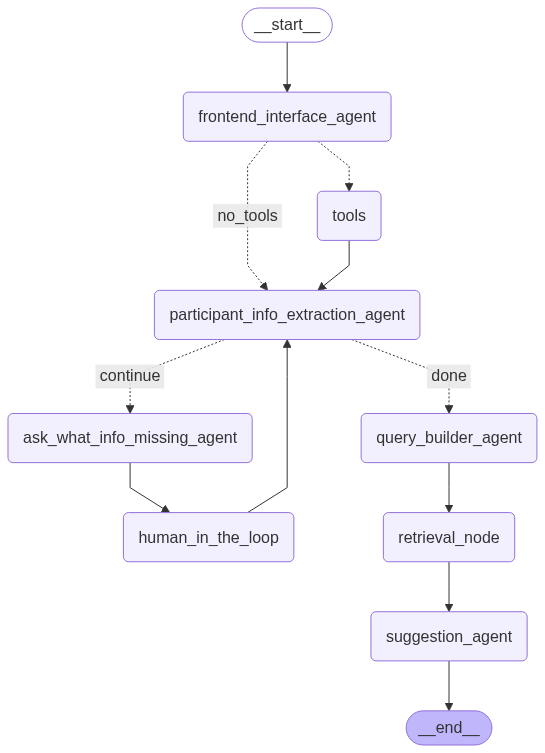

In [277]:
from IPython.display import Image, display

memory = MemorySaver()

graph_builder = StateGraph(State)
tool_node = BasicToolNode(tools=tools)

graph_builder.add_node("frontend_interface_agent", frontend_interface_agent)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("participant_info_extraction_agent", participant_info_extraction_agent)
graph_builder.add_node("ask_what_info_missing_agent", ask_what_info_missing_agent)
graph_builder.add_node("human_in_the_loop", human_in_the_loop)
graph_builder.add_node("query_builder_agent", query_builder_agent)
graph_builder.add_node("retrieval_node", retrieval_node)
graph_builder.add_node("suggestion_agent", suggestion_agent)

graph_builder.add_edge(START, "frontend_interface_agent")
graph_builder.add_conditional_edges(
    "frontend_interface_agent", 
    route_tools,
    {
        "tools": "tools",
        "no_tools": "participant_info_extraction_agent"
    }
)
graph_builder.add_conditional_edges(
    "participant_info_extraction_agent",
    check_completion,
    {
        "done": "query_builder_agent",
        "continue": "ask_what_info_missing_agent"
    }
)
graph_builder.add_edge("tools", "participant_info_extraction_agent")
graph_builder.add_edge("ask_what_info_missing_agent", "human_in_the_loop")
graph_builder.add_edge("human_in_the_loop", "participant_info_extraction_agent")
graph_builder.add_edge("query_builder_agent", "retrieval_node")
graph_builder.add_edge("retrieval_node", "suggestion_agent")
graph_builder.add_edge("suggestion_agent", END)

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Running the graph

In [ ]:
config = {"configurable": {"thread_id": "10"}}

def stream_graph_updates(user_input: str):
    for event in graph.stream(
        {
            "messages": [{"role": "user", "content": user_input}],
        },
        config=config
    ):
        print(event)
        # for value in event.values():
        #     if value["messages"][-1].content:
        #         print("Assistant:", value["messages"][-1].content)
        #         print()

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except Exception as e:
        print(e)
        break

!!!!!
--- Calling Model Agent ---
{'frontend_interface_agent': {'messages': [AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 270, 'total_tokens': 280, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'solar-pro-250422', 'system_fingerprint': None, 'id': '78e0bda0-23f9-4e35-b27c-589533b5d9c1', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--74e6402c-fd96-44d0-9dfa-a8f6046f79c9-0', usage_metadata={'input_tokens': 270, 'output_tokens': 10, 'total_tokens': 280, 'input_token_details': {}, 'output_token_details': {}})]}}
input_variables=['messages'] input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMess

KeyboardInterrupt: Interrupted by user